In [1]:
vesc = 544.0 #Escape velocity
sigmav = 156.0  #Velocity dispersion (v_0/sqrt(2))
ve = 232.0  #Earth peculiar velocity around GC


In [2]:
sigmav, ve, vesc

(156.0, 232.0, 544.0)

In [3]:
v_0=238
vp = (232**2-220**2)**0.5
ve = (v_0**2+vp**2)**0.5
sigmav = v_0/ (2**0.5)
vesc = 544.0

In [4]:
sigmav, ve, vesc

(168.2914139223983, 249.134501825821, 544.0)

In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp2d
import scipy.special
import os
    
phi_interp = None

#------- Velocity distribution stuff----------
#----------------------------------------------




# Nesc - normalisation constant
Nesc = (scipy.special.erf(vesc/(np.sqrt(2.0)*sigmav)) - np.sqrt(2.0/np.pi)*(vesc/sigmav)*np.exp(-vesc**2/(2.0*sigmav**2)))
NNORM = Nesc*156.0**3*np.sqrt(2.0*np.pi)*2.0*np.pi

#Load an interpolation function for the integral
#of the Maxwell-Boltzmann velocity distribution
#over phi
#*This is called as soon as the module is loaded*
def loadPhiInterp():
    global phi_interp
#     curr_dir = os.path.dirname(os.path.realpath(__file__)) + '/'
#     fname = curr_dir + "../data/PhiIntegrals.dat"
    xvals = np.arange(-7, 7.001, 0.05)
    phivals = np.arange(0, np.pi+0.1, 0.05)
    xlen = len(xvals)
    ylen = len(phivals)
#     #print xlen, ylen
#     if (os.path.isfile(fname)):
#         data = np.loadtxt(fname, usecols=(2,))
#         z = data.reshape((xlen,ylen))


    print(">MAXWELLBOLTZMANN: File '../data/PhiIntegrals.dat' doesn't exist...")
    print(">MAXWELLBOLTZMANN: Calculating from scratch...")
    z = np.zeros((xlen, ylen))
    for i,x in enumerate(xvals):
        for j,phi in enumerate(phivals):
            z[i,j] = quad(lambda y: np.exp(x*np.cos(y)), 0, phi)[0]

    xgrid, phigrid = np.meshgrid(xvals, phivals, indexing='ij')
#         np.savetxt(fname, zip(xgrid.flatten(), phigrid.flatten(),z.flatten()))

    phi_interp = interp2d(xvals,phivals,z.T)

loadPhiInterp()

def IntegralOverPhi(x, phi_max):
    if (phi_max < 0):
        return 0
    if (phi_max >= np.pi):
        return 2.0*np.pi*scipy.special.i0(x)
    else: 
        return 2.0*phi_interp(x, phi_max)

IntegralOverPhiVec = np.vectorize(IntegralOverPhi)

#Integrand for integrating over the velocity distribution
#The phi integral has already been performed, so all you have
#left is v and theta.
def calcf_integ(v, theta, gamma):
    
    if (v*np.sin(gamma)*np.sin(theta) <= 1e-10):
        return 2.0*np.pi*VelDist(v, theta, 0, gamma)
    
    delsq = v**2 + ve**2 - 2*v*ve*np.cos(gamma)*np.cos(theta)
    
    cosmin = (v**2 + ve**2 - vesc**2)/(2*v*ve*np.sin(gamma)*np.sin(theta))\
         - (np.cos(gamma)*np.cos(theta))/(np.sin(gamma)*np.sin(theta))
    
    
    x0 = np.sin(theta)*np.sin(gamma)*v*ve/(sigmav**2)
    phi_max = np.arccos(np.clip(cosmin, -1.0, 1.0))
    A = IntegralOverPhiVec(x0, phi_max)*np.exp(-delsq/(2.0*sigmav**2))
    
    return A*1.0/NNORM
    
#Full 3-D velocity distribution (v, theta, phi)
def VelDist(v, theta, phi, gamma):
    cdel = np.sin(gamma)*np.sin(theta)*np.cos(phi) + np.cos(gamma)*np.cos(theta)
    dsq = v**2 - 2*v*ve*cdel + ve**2
    A = np.exp(-dsq/(2*sigmav**2))/NNORM
    if hasattr(A, "__len__"):
        A[np.where(dsq > vesc**2)] = A[np.where(dsq > vesc**2)]*0.0
    else:
        if (dsq > vesc**2):
            A = 0
    return A

#Calculate the free MB speed distribution 
#after integrating over all angles
def calcf_SHM(v):
    beta = ve/(sigmav**2)
    N1 = 1.0/(Nesc*sigmav**3*np.sqrt(2*np.pi))
    f = v*0.0
    
    a = (v <= vesc-ve)
    f[a] = np.exp(-(v[a]**2 + ve**2)/(2.0*sigmav**2))*(np.exp(beta*v[a])-np.exp(-beta*v[a]))
    
    b = (vesc-ve < v)&(v < vesc+ve)
    f[b] = np.exp(-(v[b]**2 + ve**2)/(2.0*sigmav**2))*(np.exp(beta*v[b]) - np.exp((v[b]**2 + ve**2 -vesc**2)/(2*sigmav**2)))
    return f*v*N1/beta

#Minimum velocity required for a recoil of energy E_R
def vmin(E, m_N, m_x):
    res = E*0.0
    m_N2 = m_N*0.9315
    mu = (m_N2*m_x)/(m_N2+m_x)
    res =  3e5*np.sqrt((E/1e6)*(m_N2)/(2*mu*mu))
    return res

>MAXWELLBOLTZMANN: File '../data/PhiIntegrals.dat' doesn't exist...
>MAXWELLBOLTZMANN: Calculating from scratch...


In [6]:
x=np.linspace(0,1000,100)
f=calcf_SHM(x)

In [7]:
import matplotlib.pyplot as plt

In [8]:
print(dict(x=list(x), f=list(f)))

{'x': [0.0, 10.1010101010101, 20.2020202020202, 30.3030303030303, 40.4040404040404, 50.505050505050505, 60.6060606060606, 70.7070707070707, 80.8080808080808, 90.9090909090909, 101.01010101010101, 111.1111111111111, 121.2121212121212, 131.3131313131313, 141.4141414141414, 151.5151515151515, 161.6161616161616, 171.7171717171717, 181.8181818181818, 191.91919191919192, 202.02020202020202, 212.1212121212121, 222.2222222222222, 232.3232323232323, 242.4242424242424, 252.5252525252525, 262.6262626262626, 272.7272727272727, 282.8282828282828, 292.9292929292929, 303.030303030303, 313.1313131313131, 323.2323232323232, 333.3333333333333, 343.4343434343434, 353.5353535353535, 363.6363636363636, 373.73737373737373, 383.83838383838383, 393.93939393939394, 404.04040404040404, 414.1414141414141, 424.2424242424242, 434.3434343434343, 444.4444444444444, 454.5454545454545, 464.6464646464646, 474.7474747474747, 484.8484848484848, 494.9494949494949, 505.050505050505, 515.1515151515151, 525.2525252525252, 53

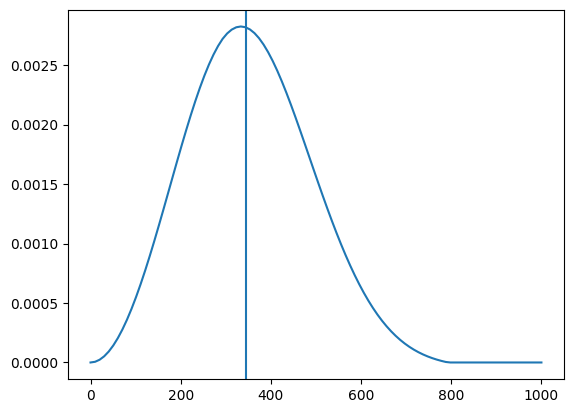

In [9]:
plt.plot(x,f)
plt.axvline(np.sqrt(ve**2+v_0**2))

In [11]:
(np.sqrt(ve**2+v_0**2))

344.5460781956457